In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gc

In [2]:
with open('hansard-speeches-post2010-lemmatized-agg-ngrams.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df

speech  \
date       heading                                           display_as                                                          
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Alan Beith      I usually enjoy and can be quite entertained b...   
                                                             Andrew Miller   On a point of order, Mr. Speaker.It might help...   
                                                             Andrew Selous   I want to pick the right hon. Gentleman up on ...   
                                                             Anne Begg       I pay tribute to the new hon. Member for Watfo...   
                                                             Charles Walker  Mr Deputy Speaker, thank you for calling me to...   
...                                                                                                                        ...   
2019-11-05 Valedictory Debate                                Seema Kennedy   On a point of order, Madam Deputy Speaker. As ...   
                                                             Stephen Pound   May I begin by apologising, Madam Deputy Speak...   
                                                             Stephen Twigg   It is a pleasure to follow the hon. Member for...   
                                                             Teresa Pearce   I would like to thank my fantastic family, my ...   
                                                             Valerie Vaz     Thank you, Mr Speaker. I congratulate you on y...   

                                                                                                                 lemmas_ngrams  
date       heading                                           display_as                                                         
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] Alan Beith      [usually, enjoy, entertain, speech, manchester...  
                                                             Andrew Miller   [order, speaker, help, particularly, seek, cat...  
                                                             Andrew Selous   [pick, gentleman, different, talk, health, spe...  
                                                             Anne Begg       [pay_tribute, new, watford, richard, harringto...  
                                                             Charles Walker  [mr_deputy_speaker, thank, call, speak, day, q...  
...                                                                                                                        ...  
2019-11-05 Valedictory Debate                                Seema Kennedy   [order, madam_deputy_speaker, order, seek, gui...  
                                                             Stephen Pound   [begin, apologise, madam_deputy_speaker, north...  
                                                             Stephen Twigg   [pleasure_follow, north, devon, peter, heaton,...  
                                                             Teresa Pearce   [like, thank, fantastic, family, staff, amazin...  
                                                             Valerie Vaz     [thank, mr_speaker, congratulate, victory, spe...  

[98174 rows x 2 columns]

In [4]:
# https://stackoverflow.com/questions/62167850/python3-multiprocessing-pool-unbalanced-cpu-usage-on-compute-engine
# "NumPy computations are not bound to any process, and need to to configured before running Python program"
# "each NumPy related computation is restricted to its own assigned process"
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

## Prepare gensim dictionary

In [5]:
from gensim.corpora.dictionary import Dictionary

texts = df.lemmas_ngrams.values

d = Dictionary(texts)
corpus = [d.doc2bow(doc) for doc in texts]

## MALLET LDA

In [6]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
import csv

In [7]:
def train_mallet(corpus, id2word_dict, n_topics_vals, folder_path='topic-models', workers=7, mallet_path='~/mallet/mallet-2.0.8/bin/mallet', random_seed=1):
    for n in n_topics_vals:
        print(f'starting training {n}')
        
        # train mallet lda model of with n topics
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=id2word_dict,
                          random_seed=random_seed, iterations=250, 
                          alpha=20, #lower than default 50. Intuition: few speeches in parliament discuss more than one topic
                          workers=workers) 
        print(f'{n} lda done')

        # save mallet lda model
        with open(f'{folder_path}/lda_mallet_{n}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f'saved {n} lda')    

        # load document-topic matrix from file
        doc_topics_df = pd.read_csv(f'{model.fdoctopics()}', sep='\t', lineterminator='\n', header=None)
        doc_topics = doc_topics_df.values[:,2:]
        
        # if it doesn't exist, create doc-topics folder
        if not os.path.exists(f'{folder_path}/doc-topics'):
            os.makedirs(f'{folder_path}/doc-topics')
        
        # save doc_topics matrix to doc-topics folder
        with open(f'{folder_path}/doc-topics/lda_mallet_{n}_doc_topics.pkl', 'wb') as f:
            pickle.dump(doc_topics, f)
        print(f'saved {n} doc-topics')
        
        # clear from memory 
        del model
        del doc_topics
        del doc_topics_df
        gc.collect()
        print(f'done {n}\n')

        
def get_mallet_coherence(metrics, n_topics_vals, folder_path='topic-models', new_coherence_log=False, workers=-1, coherence_log_fname='coherences'):
    # if it doesn't exist, create coherence folder
    if not os.path.exists(f'{folder_path}/coherence'):
        os.makedirs(f'{folder_path}/coherence')
            
    # if it doesn't exist, create gensim folder
    if not os.path.exists(f'{folder_path}/gensim'):
        os.makedirs(f'{folder_path}/gensim')
    
    # if coherences log doesn't exist
    if not os.path.isfile(f'{folder_path}/coherence/{coherence_log_fname}.csv'):
        # initialize coherences log file
        with open(f'{folder_path}/coherence/{coherence_log_fname}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['n_topics'] + metrics)
    
    # for each n_topics value
    for n in n_topics_vals:
        print(f'starting coherence {n}')
        
        # load relevant lda mallet model
        with open(f'{folder_path}/lda_mallet_{n}.pkl', 'rb') as f:
            model = pickle.load(f)
        print('loaded mallet model')
        
        # convert lda mallet model to gensim lda model and save to gensim folder
        gensim_lda_model = malletmodel2ldamodel(model)
        with open(f'{folder_path}/gensim/lda_gensim_{n}.pkl', 'wb') as f:
            pickle.dump(gensim_lda_model, f)
        print('converted to gensim')
        
        coherence = []
        for metric in metrics:
            if metric == 'u_mass':
                coherence_model = CoherenceModel(model=gensim_lda_model, corpus=corpus, coherence=metric, processes=workers)
            else:
                coherence_model = CoherenceModel(model=gensim_lda_model, texts=texts, coherence=metric, processes=workers)
            
            with open(f'{folder_path}/coherence/coherence_model_{metric}_{n}.pkl', 'wb') as f:
                pickle.dump(coherence_model, f)
            
            coherence.append(coherence_model.get_coherence())
        
        res = [str(n)] + [str(x) for x in coherence]
        with open(f'{folder_path}/coherence/{coherence_log_fname}.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(res)
            
        print('calculated coherence')
        
        del model
        del gensim_lda_model
        gc.collect()
        
        print(f'done {n}\n')

# Experiments

In [8]:
if not os.path.exists(f'topic-models'):
    os.makedirs(f'topic-models')

## Coarse

### Train and save models

In [8]:
n_topics_vals = np.concatenate([
    np.arange(10,100,10),
    np.arange(100,301,20),
    np.arange(350, 501, 50)
])
n_topics_vals

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 120, 140, 160,
       180, 200, 220, 240, 260, 280, 300, 350, 400, 450, 500])

In [10]:
exp_path = 'coarse'
if not os.path.exists(f'topic-models/{exp_path}'):
    os.makedirs(f'topic-models/{exp_path}')

In [11]:
train_mallet(corpus=corpus, id2word_dict=d, 
             n_topics_vals=n_topics_vals, 
             folder_path=f'topic-models/{exp_path}', 
             workers=15)
print('done training')

starting training 10
10 lda done
saved 10 lda
saved 10 doc-topics
done 10

starting training 20
20 lda done
saved 20 lda
saved 20 doc-topics
done 20

starting training 30
30 lda done
saved 30 lda
saved 30 doc-topics
done 30

starting training 40
40 lda done
saved 40 lda
saved 40 doc-topics
done 40

starting training 50
50 lda done
saved 50 lda
saved 50 doc-topics
done 50

starting training 60
60 lda done
saved 60 lda
saved 60 doc-topics
done 60

starting training 70
70 lda done
saved 70 lda
saved 70 doc-topics
done 70

starting training 80
80 lda done
saved 80 lda
saved 80 doc-topics
done 80

starting training 90
90 lda done
saved 90 lda
saved 90 doc-topics
done 90

starting training 100
100 lda done
saved 100 lda
saved 100 doc-topics
done 100

starting training 120
120 lda done
saved 120 lda
saved 120 doc-topics
done 120

starting training 140
140 lda done
saved 140 lda
saved 140 doc-topics
done 140

starting training 160
160 lda done
saved 160 lda
saved 160 doc-topics
done 160

start

In [ ]:
get_mallet_coherence(metrics=['c_npmi', 'c_v'], n_topics_vals=n_topics_vals, 
                     folder_path=f'topic-models/{exp_path}', new_coherence_log=True, coherence_log_fname='coherences', 
                     workers=15)
print('done coherence')

starting coherence 10
loaded mallet model
converted to gensim
calculated coherence
done 10

starting coherence 20
loaded mallet model
converted to gensim
calculated coherence
done 20

starting coherence 30
loaded mallet model
converted to gensim
calculated coherence
done 30

starting coherence 40
loaded mallet model
converted to gensim
calculated coherence
done 40

starting coherence 50
loaded mallet model
converted to gensim
calculated coherence
done 50

starting coherence 60
loaded mallet model
converted to gensim
calculated coherence
done 60

starting coherence 70
loaded mallet model
converted to gensim
calculated coherence
done 70

starting coherence 80
loaded mallet model
converted to gensim
calculated coherence
done 80

starting coherence 90
loaded mallet model
converted to gensim
calculated coherence
done 90

starting coherence 100
loaded mallet model
converted to gensim
calculated coherence
done 100

starting coherence 120
loaded mallet model
converted to gensim
calculated cohe

### plot results

In [11]:
c_df = pd.read_csv('topic-models/coarse/coherence/coherences.csv', index_col=0, header=None).rename(columns={1:'c_npmi', 2:'c_v'})

In [12]:
c_df

,c_npmi,c_v
0,,
10,0.044172,0.468788
20,0.059928,0.509376
30,0.060984,0.507825
40,0.067710,0.520545
50,0.068674,0.520935
60,0.070203,0.524909
70,0.074331,0.533920
80,0.074825,0.532787
90,0.077591,0.538810


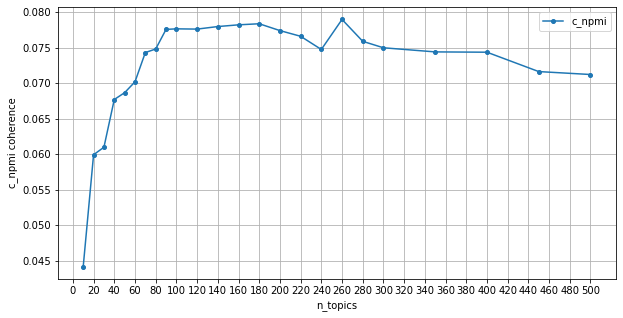

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
c_df.plot(y='c_npmi', ax=ax, marker='o', markersize=4)
plt.xticks(np.arange(0,501,20))
# ax.axhspan(0.078, 0.081, color='r', alpha=0.25)
# plt.ylim(())
# ax.axvspan(140, 330, alpha=0.25, color='r')
# ax.axvspan(140, 170, alpha=0.25, color='r')
# c_df[c_df.c_npmi > .0785].reset_index().plot.scatter(x='n_topics', y='c_npmi', ax=ax)
plt.xlabel('n_topics')
plt.ylabel('c_npmi coherence')
plt.grid()

best model by c_npmi: 160 topics

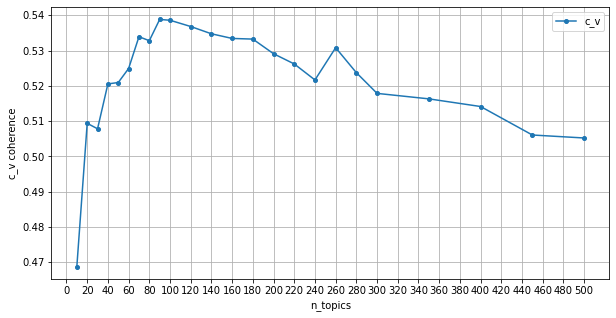

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
c_df.plot(y='c_v', ax=ax, marker='o', markersize=4)
plt.xticks(np.arange(0,501,20))
# ax.axhspan(0.078, 0.081, color='r', alpha=0.25)
# plt.ylim(())
# ax.axvspan(140, 330, alpha=0.25, color='r')
# ax.axvspan(140, 170, alpha=0.25, color='r')
# c_df[c_df.c_npmi > .0785].reset_index().plot.scatter(x='n_topics', y='c_npmi', ax=ax)
plt.xlabel('n_topics')
plt.ylabel('c_v coherence')
plt.grid()

In [15]:
cv_norm = (c_df.c_v.values - np.min(c_df.c_v.values)) / (np.max(c_df.c_v.values) - np.min(c_df.c_v.values))
cnpmi_norm = (c_df.c_npmi.values - np.min(c_df.c_npmi.values)) / (np.max(c_df.c_npmi.values) - np.min(c_df.c_npmi.values))

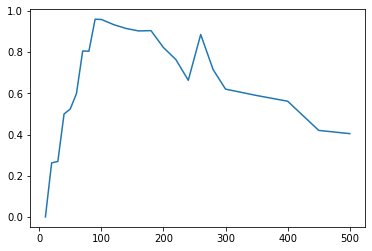

In [16]:
plt.plot(c_df.index, cv_norm * cnpmi_norm)

best model by c_v: 70 topics

# Exploring Ieff and top topic p distributions

In [17]:
def make_probs(size, n_att_topics, p_topics=.6):
    if size < n_att_topics:
        return np.array([])
    else:
        return np.concatenate([np.repeat(p_topics/n_att_topics, n_att_topics), 
                               np.repeat( (1-p_topics)/(size-n_att_topics), (size-n_att_topics) )])

## 90

### Load files

In [18]:
N = 90

with open(f'topic-models/coarse/doc-topics/lda_mallet_{N}_doc_topics.pkl', 'rb') as f:
    dt = pickle.load(f)
    
with open(f'topic-models/coarse/lda_mallet_{N}.pkl', 'rb') as f:
    lda = pickle.load(f)

In [19]:
dt.shape

(98174, 90)

## Plot Ieff distribution

In [111]:
from scipy.stats import entropy
def plot_Ieff(dt, n_top=5, att=.75, bins=100):
    S = entropy(dt, base=2, axis=1)
    Ieff = 2**S
    
    syn_probs = make_probs(160, 5, .75)
    syn_Ieff = 2**entropy(syn_probs, base=2)
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(Ieff, bins=bins)
    ax.axvline(syn_Ieff, c='r', alpha=0.5)
    plt.show()

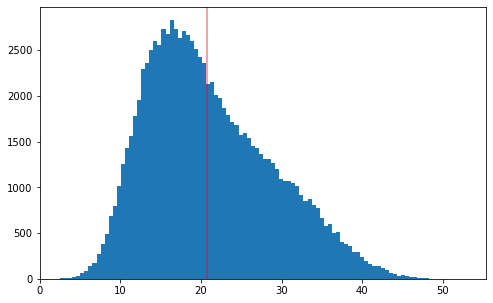

In [68]:
plot_Ieff(dt)

In [160]:
def review_doc(ind, n_top_p=3):
    print(f'doc id: {ind}', '\n')

    print('Ieff:', Ieff[ind], '\n')
    
    print(f'top {n_top_p} topic ps:', np.sum(np.sort(dt[ind])[::-1][:n_top_p]), '\n')

    print('Largest doc topic probs', np.sort(dt[ind])[::-1][:12], '\n')

    for i, topic_id in enumerate(np.argsort(dt[ind])[::-1][:5]):
        print(np.around( np.sort(dt[ind])[::-1][i], 3 ), topic_id)
        print(lda.print_topic(topic_id))
        print('\r')

    print(df.iloc[ind].speech)

In [60]:
ind = np.random.choice(np.where(Ieff < 5)[0])
review_doc(ind)

26879 

Ieff: 4.734160598534849 

top 3 topic ps: 0.8596961572832886 

[0.62794161 0.17753947 0.05421507 0.01936253 0.0140006  0.00863867
 0.00863867 0.0059577  0.00327674 0.00327674 0.00327674 0.00327674] 

0.628 25
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

0.178 48
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

0.054 9
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

0.019 67
0.061*"money" + 0.055*"funding" + 0.054*"million" + 0.038*"fund" + 0.037*"billion" + 0.034*"spend" + 0.033*"budget" + 0.021*"cost" + 0.019*"spending" + 0.019*"increase"

0.014 19
0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*

## Plot topic p distributions

In [72]:
def topic_i_p(dt,i,j=None):
    if j is not None:
        return np.sum([topic_i_p(dt, n) for n in np.arange(i,j)], axis=0)
    else:
        return np.sort(dt, axis=1)[:, ::-1][:,i]

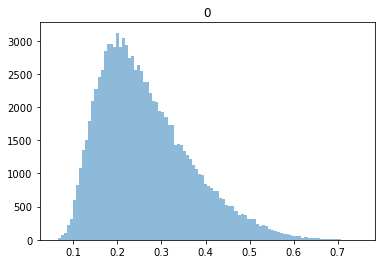

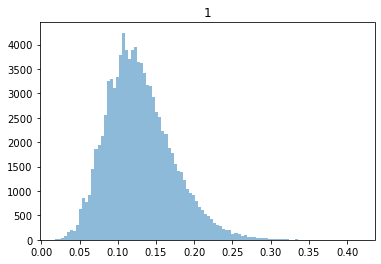

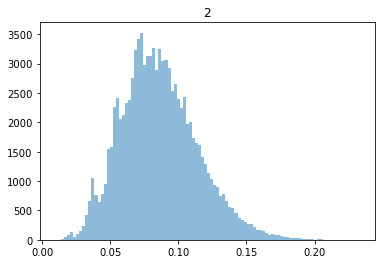

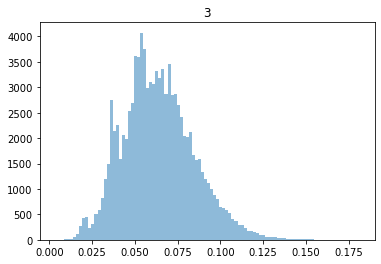

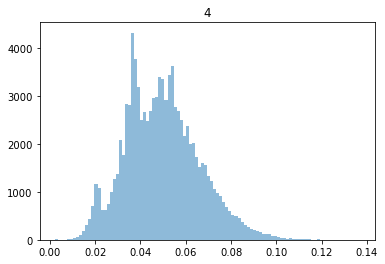

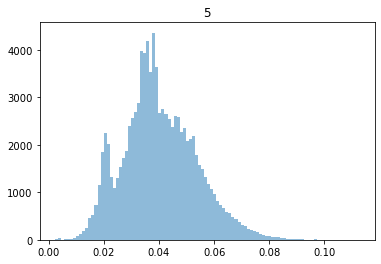

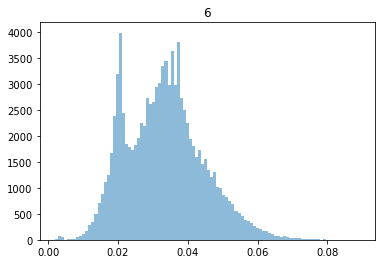

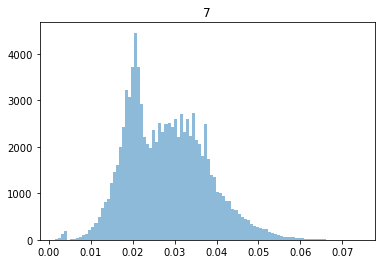

In [70]:
for i in range(8):
    plt.hist(topic_i_p(dt, i), bins=100, alpha=0.5)
    plt.title(i)
    plt.show()

* changing shape of distribution (growing peak around 0.02 - lda averages small amount over many topics, so all end up with the around the same small value) 
* shape change visible in 2, strong in 3
* motivates decision to take sum of no more than top 3 topic probabilities (from 0 up to and including 2)

In [79]:
def get_suffix(n):
    if n==1:
        return 'st'
    elif n==2:
        return 'nd'
    elif n==3:
        return 'rd'
    else:
        return 'th'

In [168]:
def plot_top_p_hist(dt, top_p=3, bins=100, title=''):
    for i in range(top_p):
        plt.hist(topic_i_p(dt,i), bins=bins, alpha=0.5, label=f'{i}{get_suffix(i)}')
    plt.hist(topic_i_p(dt,0,n), bins=bins, alpha=0.5, label=f'sum of top {top_p}')
    plt.xlabel(f'document topic probability')
    plt.ylabel('frequency')
    plt.legend(title='nth highest doc prob')
    plt.title(title)
    plt.show()

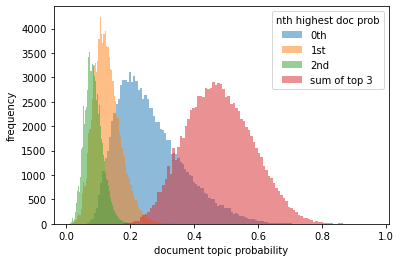

In [83]:
plot_top_p_hist(dt, 3)

In [42]:
len(np.where(topic_i_p(0,3) > .5)[0])/len(df)

0.41197262004196633

In [45]:
ind = np.random.choice(np.where(topic_i_p(0,3) < 0.6)[0])
# ind = np.random.choice(np.where(Ieff > 40)[0])
review_doc(ind, 3)

19885 

Ieff: 31.73694123137175 

top 3 topic ps: 0.38888888888888873 

[0.21548822 0.10942761 0.06397306 0.04882155 0.03367003 0.03367003
 0.03367003 0.03367003 0.03367003 0.01851852 0.01851852 0.01851852] 

0.215 0
0.041*"immigration" + 0.028*"uk" + 0.021*"citizen" + 0.018*"british" + 0.017*"home_secretary" + 0.014*"home_office" + 0.014*"national" + 0.014*"system" + 0.013*"border" + 0.011*"number"

0.109 13
0.209*"child" + 0.062*"family" + 0.040*"parent" + 0.020*"young" + 0.020*"care" + 0.017*"early" + 0.012*"life" + 0.010*"start" + 0.010*"social" + 0.010*"age"

0.064 65
0.019*"refugee" + 0.014*"humanitarian" + 0.014*"conflict" + 0.014*"international" + 0.013*"yemen" + 0.012*"uk" + 0.012*"syria" + 0.010*"situation" + 0.009*"million" + 0.009*"provide"

0.049 87
0.045*"inquiry" + 0.029*"report" + 0.023*"investigation" + 0.021*"evidence" + 0.013*"happen" + 0.011*"question" + 0.010*"independent" + 0.009*"case" + 0.009*"public" + 0.009*"allegation"

0.034 77
0.015*"human" + 0.014*"iran" +

## Plot Ieff, no. lemmas, and sum of topic probs against each other

In [46]:
length = df.lemmas_ngrams.apply(len).values

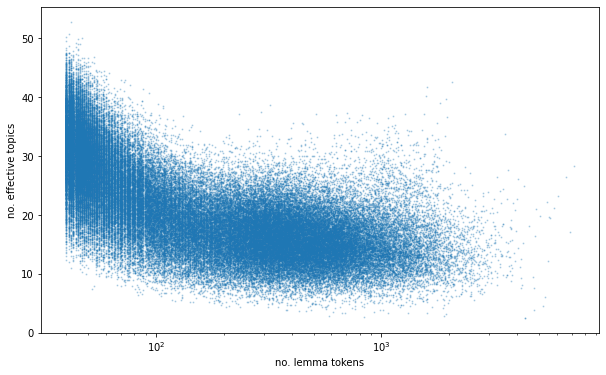

In [47]:
plt.figure(figsize=(10,6))
plt.scatter(length, Ieff, s=1, alpha=0.25)
plt.xlabel('no. lemma tokens')
plt.ylabel('no. effective topics')
plt.xscale('log')
# plt.yscale('log')

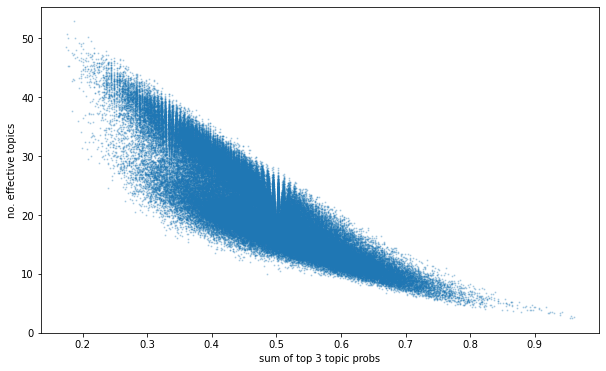

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(topic_i_p(0,3), Ieff, s=1, alpha=0.25)
plt.xlabel('sum of top 3 topic probs')
plt.ylabel('no. effective topics')
plt.show()
# plt.xscale('log')
# plt.yscale('log')

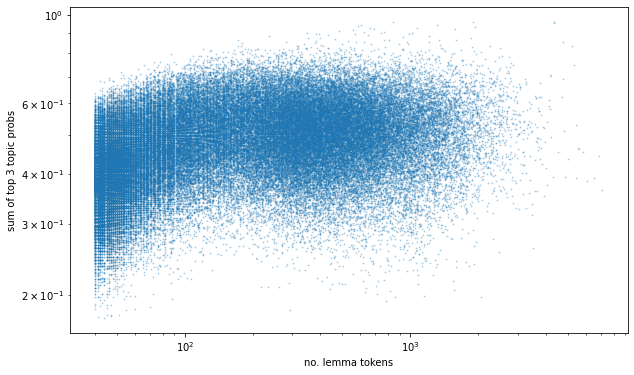

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(length, topic_i_p(0,3), s=1, alpha=0.25)
plt.xlabel('no. lemma tokens')
plt.ylabel('sum of top 3 topic probs')
plt.xscale('log')
plt.yscale('log')

### Investigating "stop-topics"

### 90

25
* 0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

48
* 0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

9
* 0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

83
* 0.033*"mr" + 0.023*"south" + 0.019*"north" + 0.018*"debate" + 0.016*"speak" + 0.014*"speech" + 0.013*"hear" + 0.012*"west" + 0.011*"mention" + 0.011*"east"

82
* 0.041*"petition" + 0.020*"recall" + 0.020*"urge" + 0.019*"constituent" + 0.017*"sign" + 0.017*"state" + 0.017*"commons" + 0.016*"mr" + 0.013*"john" + 0.011*"constituency"

19
* 0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*"ensure" + 0.028*"raise" + 0.025*"absolutely" + 0.019*"question" + 0.016*"make" + 0.016*"continue" + 0.015*"happy"

(36)
* (0.038*"regulation" + 0.024*"power" + 0.020*"ensure" + 0.018*"legislation" + 0.013*"require" + 0.012*"act" + 0.012*"standard" + 0.011*"provide" + 0.011*"set" + 0.011*"protection")

In [189]:
stop_topics = [25, 48, 9, 83, 82, 19]

In [102]:
top_topic = np.argsort(dt, axis=1)[:,-1]

In [190]:
ind = np.random.choice(np.where(top_topic==25)[0])
review_doc(ind)

doc id: 79077 

Ieff: 30.94353597992911 

top 3 topic ps: 0.4152046783625729 

Largest doc topic probs [0.24951267 0.09161793 0.07407407 0.05653021 0.03898635 0.0214425
 0.0214425  0.0214425  0.0214425  0.0214425  0.0214425  0.0214425 ] 

0.25 25
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

0.092 35
0.073*"parliament" + 0.017*"lords" + 0.016*"power" + 0.014*"vote" + 0.014*"elect" + 0.014*"place" + 0.013*"reform" + 0.013*"party" + 0.012*"constitutional" + 0.012*"change"

0.074 53
0.084*"prime_minister" + 0.032*"week" + 0.030*"question" + 0.022*"secretary" + 0.021*"answer" + 0.021*"statement" + 0.019*"today" + 0.016*"leader" + 0.016*"yesterday" + 0.014*"plan"

0.057 27
0.035*"thing" + 0.022*"problem" + 0.019*"happen" + 0.014*"talk" + 0.013*"lot" + 0.011*"find" + 0.010*"money" + 0.009*"deal" + 0.009*"idea" + 0.009*"sort"

0.039 9
0.073*"order" + 0.056*"gentleman" +

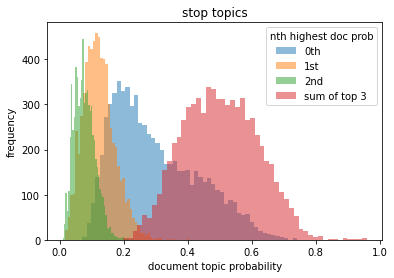

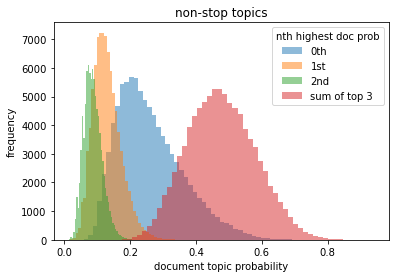

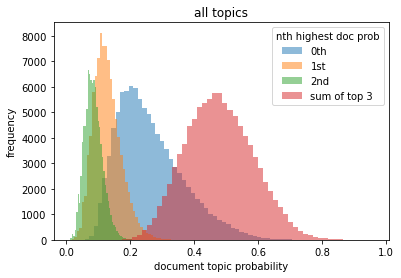

In [169]:
dt_stop = dt[np.isin(top_topic, stop_topics)]
dt_notstop = dt[np.logical_not(np.isin(top_topic, stop_topics))]

plot_top_p_hist(dt_stop, 3, 50, title='stop topics')
plot_top_p_hist(dt_notstop, 3, 50, title='non-stop topics')
plot_top_p_hist(dt, 3, 50, title='all topics')

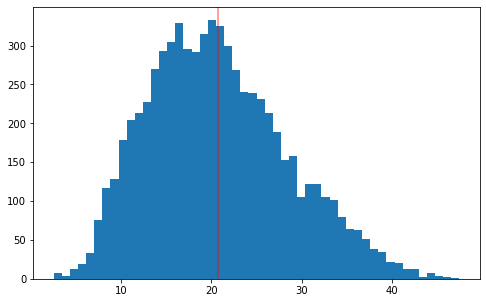

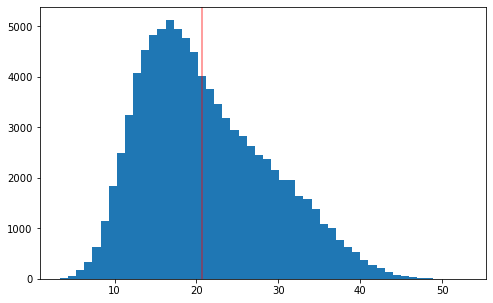

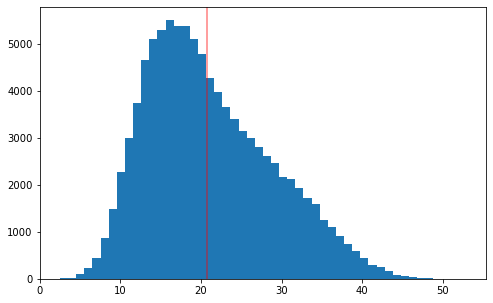

In [172]:
plot_Ieff(dt_stop, n_top=5, att=.75, bins=50)
plot_Ieff(dt_notstop, n_top=5, att=.75, bins=50)
plot_Ieff(dt, n_top=5, att=.75, bins=50)

"bill/amendment" topic id: 48

In [175]:
df_conv = df[df.speech.str.lower().str.contains("with this it will be convenient to discuss the following")]

In [194]:
df_conv.sample().speech.values

array(['With this it will be convenient to discuss the following:New clause 2 — Review of operation of gift aid matching rule — ‘(1) The Small Charitable Donations Act 2012 is amended as follows.(2) After section 16, insert the following — “16A Review of operation of gift aid matching rule(1) The Chancellor of the Exchequer shall, no later than the end of the 2017-18 tax year, undertake a review of the operation of the gift aid matching rule.(2) As part of the review of under subsection (1), the Chancellor of the Exchequer shall consult charities and other organisations that he considers relevant about — (a) the role of the gift aid matching rule in preventing fraud and abuse, and(b) the appropriateness of the Treasury exercising its order-making powers under section 14(2).(3) A report of the review undertaken in accordance with this section must be laid before each House of Parliament by the Chancellor of the Exchequer.(4) In this section, “the gift aid matching rule” has the same mea